# Libraries

In [4]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Conv2DTranspose, Reshape, BatchNormalization, Dropout
from keras.metrics import categorical_accuracy
from tensorflow.keras.losses import Loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from tensorflow.keras import layers, regularizers

# Dataset

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Functions

In [6]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Class

In [7]:
class ScaledBinaryCrossentropy:
    def __init__(self, scale=1.0):
        """
        Inicializa la clase de pérdida personalizada.
        :param scale: float, el factor de escala para la pérdida.
        :param name: str, nombre de la pérdida.
        """

        self.scale = scale

    def __call__(self, y_true, y_pred):
        """
        Calcula la pérdida escalada.
        :param y_true: Tensor, etiquetas verdaderas.
        :param y_pred: Tensor, predicciones del modelo.
        :return: Tensor, pérdida escalada.
        """
        # Calcula la binary crossentropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Retorna la binary crossentropy escalada
        return self.scale * bce

In [8]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, alpha=0.01, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = self.alpha * -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# Regularized Autoencoder

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Flatten(),
    keras.layers.Dense(400, activation="selu")
])


stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, activation="selu", input_shape=[400]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])


stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[rounded_accuracy])


history = stacked_ae.fit(X_train, X_train, epochs=100, batch_size=64,
                         validation_data=(X_valid, X_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 1.1099 - rounded_accuracy: 0.8875 - val_loss: 0.3422 - val_rounded_accuracy: 0.9223
Epoch 2/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.3362 - rounded_accuracy: 0.9248 - val_loss: 0.3289 - val_rounded_accuracy: 0.9280
Epoch 3/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3250 - rounded_accuracy: 0.9305 - val_loss: 0.3233 - val_rounded_accuracy: 0.9320
Epoch 4/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3204 - rounded_accuracy: 0.9334 - val_loss: 0.3203 - val_rounded_accuracy: 0.9341
Epoch 5/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.3178 - rounded_accuracy: 0.9352 - val_loss: 0.3185 - val_rounded_accuracy: 0.9348
Epoch 6/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3161 - rounded_accuracy: 0.9364 - val_loss: 0.3170 - val_rounded_accuracy: 0.9366
Epoch 7/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.3148 - rounded_accuracy: 0.9375 - val_loss: 0.3158 - val_rounde

# Loss

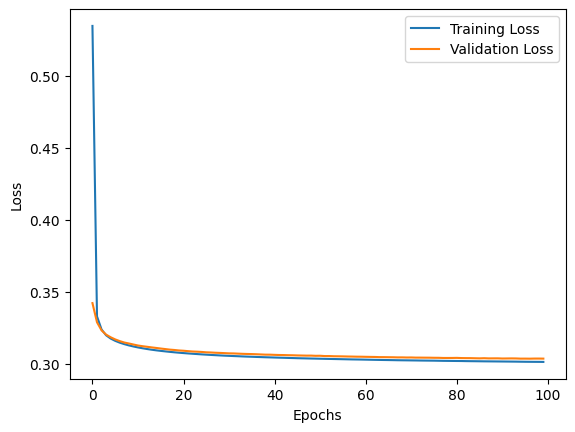

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

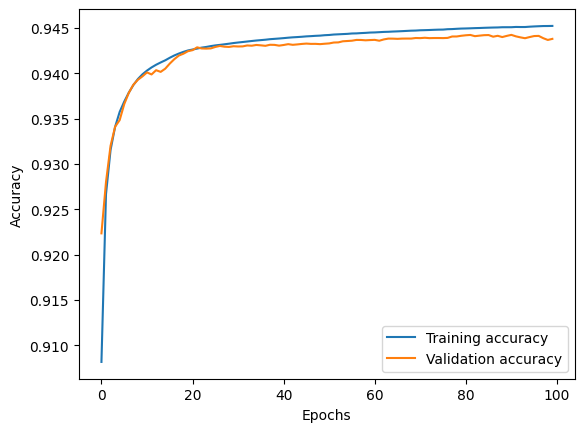

In [11]:
plt.plot(history.history['rounded_accuracy'], label='Training accuracy')
plt.plot(history.history['val_rounded_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Reconstrucción

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


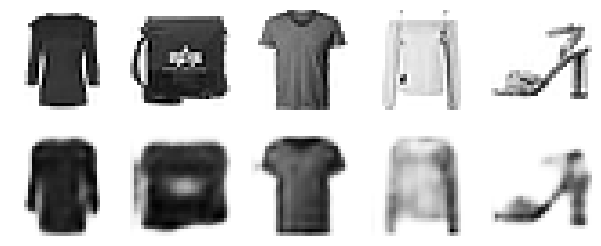

In [12]:
show_reconstructions(stacked_ae)
plt.show()

# VAE

In [13]:
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='selu', strides=2, padding='same')(encoder_inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='selu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='selu')(x)
    x = Dropout(0.3)(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7*7*64, activation='selu')(decoder_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='selu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='selu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder


In [14]:
latent_dim = 256
alpha = 0.2
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

vae = VAE(encoder, decoder, alpha=alpha)
beta= 1-alpha
loss2=ScaledBinaryCrossentropy(beta)
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])
history = vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.3503 - rounded_accuracy: 0.8270 - val_loss: 0.2929 - val_rounded_accuracy: 0.8880
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2840 - rounded_accuracy: 0.8919 - val_loss: 0.2780 - val_rounded_accuracy: 0.8997
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2718 - rounded_accuracy: 0.9014 - val_loss: 0.2678 - val_rounded_accuracy: 0.9051
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2653 - rounded_accuracy: 0.9070 - val_loss: 0.2674 - val_rounded_accuracy: 0.9071
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2620 - rounded_accuracy: 0.9098 - val_loss: 0.2607 - val_rounded_accuracy: 0.9115
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2595 - rounded_accuracy: 0.9121 - val_loss: 0.2605 - val_rounded_accuracy: 0.9104
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2580 - rounded_accuracy: 0.9134 - val_loss: 0.2600 

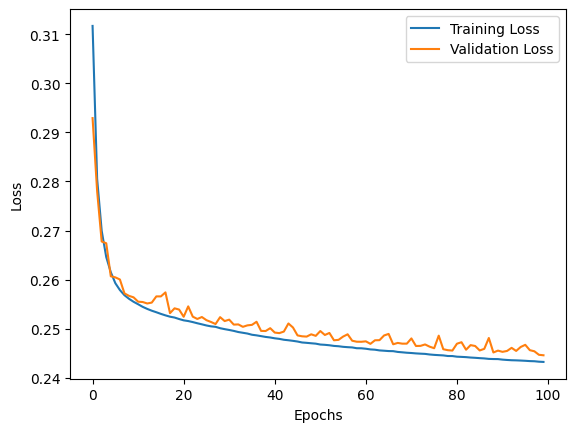

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

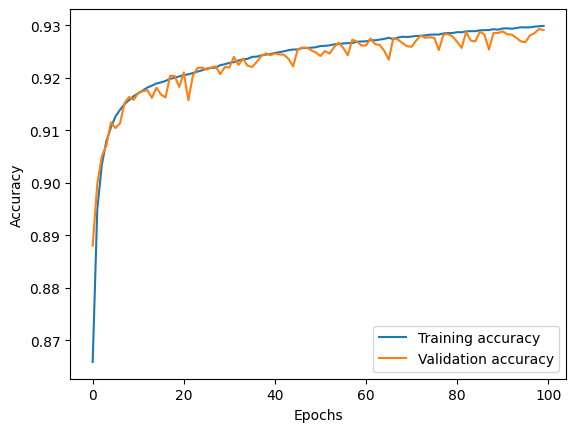

In [16]:
plt.plot(history.history['rounded_accuracy'], label='Training accuracy')
plt.plot(history.history['val_rounded_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


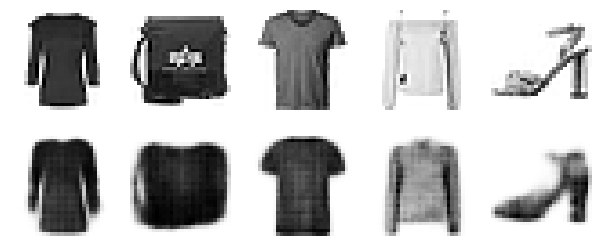

In [17]:
show_reconstructions(vae)
plt.show()